# Collect Tweets into MongoDB

## Install Python libraries

You may need to restart your Jupyter Notebook instance after installed those libraries.

In [1]:
!pip install pymongo

     |████████████████████████████████| 509 kB 23.0 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [2]:
!pip install pymongo[srv]

     |████████████████████████████████| 188 kB 15.5 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [3]:
!pip install dnspython

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [4]:
!pip install tweepy

     |████████████████████████████████| 147 kB 23.0 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [5]:
!pip install twitter

     |████████████████████████████████| 54 kB 1.9 MB/s  eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


## Import Python libraries

In [6]:
import pymongo
from pymongo import MongoClient
import json
import tweepy
import twitter
from pprint import pprint
import configparser
import pandas as pd

##  Load the Authorization Info

Save database connection info and API Keys in a config.ini file and use the configparse to load the authorization info. 

In [7]:
config = configparser.ConfigParser()
config.read('config.ini')

CONSUMER_KEY      = config['mytwitter']['api_key']
CONSUMER_SECRET   = config['mytwitter']['api_secrete']
OAUTH_TOKEN       = config['mytwitter']['access_token']
OATH_TOKEN_SECRET = config['mytwitter']['access_secrete']

mongod_connect = config['mymongo']['connection']

## Connect to the MongoDB Cluster

In [8]:
client = MongoClient(mongod_connect)
db = client.gp24 # use or create a database named demo
tweet_collection = db.lab11 #use or create a collection named tweet_collection
tweet_collection.create_index([("id", pymongo.ASCENDING)],unique = True) # make sure the collected tweets are unique

'id_1'

## Use the Streaming API to Collect Tweets

Authorize the Stream API 

In [9]:
stream_auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
stream_auth.set_access_token(OAUTH_TOKEN, OATH_TOKEN_SECRET)

strem_api = tweepy.API(stream_auth)

Define the query for the Stream API

In [5]:
track = ['election'] # define the keywords, tweets contain election

locations = [-78.9326449,38.4150904,-78.8816972,38.4450731] #defin the location, in Harrisonburg, VA

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> OR </span> are located in Harrisonburg, VA

In [ ]:
class MyStreamListener(tweepy.StreamListener):
    def on_status(self, status):
        print (status.id_str)
        try:
            tweet_collection.insert_one(status._json)
        except:
            pass
  
    def on_error(self, status_code):
        if status_code == 420:
            #returning False in on_data disconnects the stream
            return False
myStreamListener = MyStreamListener()
myStream = tweepy.Stream(auth = strem_api.auth, listener=myStreamListener)
myStream.filter(track=track)#  (locations = locations)   #Use either track or locations

## Use the REST API to Collect Tweets

Authorize the REST API 

In [10]:
rest_auth = twitter.oauth.OAuth(OAUTH_TOKEN,OATH_TOKEN_SECRET,CONSUMER_KEY,CONSUMER_SECRET)
rest_api = twitter.Twitter(auth=rest_auth)

Define the query for the REST API

In [11]:
count = 100 #number of returned tweets, default and max is 100
geocode = "37.5247764,-77.5633011,150mi"  # defin the location, in Harrisonburg, VA
q = "covid19"                               #define the keywords, tweets contain election

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> AND </span> are located in Harrisonburg, VA

In [12]:
search_results = rest_api.search.tweets( count=count,q=q, geocode=geocode) #you can use both q and geocode
statuses = search_results["statuses"]
since_id_new = statuses[-1]['id']
for statuse in statuses:
    try:
        tweet_collection.insert_one(statuse)
        pprint(statuse['created_at'])# print the date of the collected tweets
    except:
        pass

'Sun Nov 22 19:43:52 +0000 2020'
'Sun Nov 22 19:43:16 +0000 2020'
'Sun Nov 22 19:43:13 +0000 2020'
'Sun Nov 22 19:42:57 +0000 2020'
'Sun Nov 22 19:42:52 +0000 2020'
'Sun Nov 22 19:42:42 +0000 2020'
'Sun Nov 22 19:42:41 +0000 2020'
'Sun Nov 22 19:42:33 +0000 2020'
'Sun Nov 22 19:42:10 +0000 2020'
'Sun Nov 22 19:42:04 +0000 2020'
'Sun Nov 22 19:41:52 +0000 2020'
'Sun Nov 22 19:41:48 +0000 2020'
'Sun Nov 22 19:41:28 +0000 2020'
'Sun Nov 22 19:40:41 +0000 2020'
'Sun Nov 22 19:40:39 +0000 2020'
'Sun Nov 22 19:40:37 +0000 2020'
'Sun Nov 22 19:40:24 +0000 2020'
'Sun Nov 22 19:40:19 +0000 2020'
'Sun Nov 22 19:40:06 +0000 2020'
'Sun Nov 22 19:40:03 +0000 2020'
'Sun Nov 22 19:39:54 +0000 2020'
'Sun Nov 22 19:39:51 +0000 2020'
'Sun Nov 22 19:39:38 +0000 2020'
'Sun Nov 22 19:39:34 +0000 2020'
'Sun Nov 22 19:39:26 +0000 2020'
'Sun Nov 22 19:39:19 +0000 2020'
'Sun Nov 22 19:38:58 +0000 2020'
'Sun Nov 22 19:38:37 +0000 2020'
'Sun Nov 22 19:38:32 +0000 2020'
'Sun Nov 22 19:38:32 +0000 2020'
'Sun Nov 2

Continue fetching early tweets with the same query. 
<p><span style="color:red;font-weight:bold">YOU WILL REACH YOUR RATE LIMIT VERY FAST</span></p>

In [13]:
since_id_old = 0
while(since_id_new != since_id_old):
    since_id_old = since_id_new
    search_results = rest_api.search.tweets( count=count,q=q,
                        geocode=geocode, max_id= since_id_new)
    statuses = search_results["statuses"]
    since_id_new = statuses[-1]['id']
    for statuse in statuses:
        try:
            tweet_collection.insert_one(statuse)
            pprint(statuse['created_at']) # print the date of the collected tweets
        except:
            pass

'Sun Nov 22 19:26:35 +0000 2020'
'Sun Nov 22 19:26:31 +0000 2020'
'Sun Nov 22 19:26:28 +0000 2020'
'Sun Nov 22 19:26:28 +0000 2020'
'Sun Nov 22 19:26:27 +0000 2020'
'Sun Nov 22 19:25:53 +0000 2020'
'Sun Nov 22 19:25:51 +0000 2020'
'Sun Nov 22 19:25:41 +0000 2020'
'Sun Nov 22 19:25:32 +0000 2020'
'Sun Nov 22 19:25:30 +0000 2020'
'Sun Nov 22 19:25:22 +0000 2020'
'Sun Nov 22 19:25:12 +0000 2020'
'Sun Nov 22 19:25:03 +0000 2020'
'Sun Nov 22 19:25:01 +0000 2020'
'Sun Nov 22 19:24:53 +0000 2020'
'Sun Nov 22 19:24:36 +0000 2020'
'Sun Nov 22 19:24:33 +0000 2020'
'Sun Nov 22 19:24:20 +0000 2020'
'Sun Nov 22 19:24:01 +0000 2020'
'Sun Nov 22 19:23:58 +0000 2020'
'Sun Nov 22 19:23:48 +0000 2020'
'Sun Nov 22 19:23:46 +0000 2020'
'Sun Nov 22 19:23:44 +0000 2020'
'Sun Nov 22 19:23:35 +0000 2020'
'Sun Nov 22 19:23:23 +0000 2020'
'Sun Nov 22 19:23:22 +0000 2020'
'Sun Nov 22 19:23:19 +0000 2020'
'Sun Nov 22 19:23:15 +0000 2020'
'Sun Nov 22 19:22:58 +0000 2020'
'Sun Nov 22 19:22:52 +0000 2020'
'Sun Nov 2

'Sun Nov 22 18:50:17 +0000 2020'
'Sun Nov 22 18:50:16 +0000 2020'
'Sun Nov 22 18:50:15 +0000 2020'
'Sun Nov 22 18:50:14 +0000 2020'
'Sun Nov 22 18:50:12 +0000 2020'
'Sun Nov 22 18:50:02 +0000 2020'
'Sun Nov 22 18:49:49 +0000 2020'
'Sun Nov 22 18:49:48 +0000 2020'
'Sun Nov 22 18:49:46 +0000 2020'
'Sun Nov 22 18:49:43 +0000 2020'
'Sun Nov 22 18:49:42 +0000 2020'
'Sun Nov 22 18:49:41 +0000 2020'
'Sun Nov 22 18:49:38 +0000 2020'
'Sun Nov 22 18:49:26 +0000 2020'
'Sun Nov 22 18:49:26 +0000 2020'
'Sun Nov 22 18:49:24 +0000 2020'
'Sun Nov 22 18:49:21 +0000 2020'
'Sun Nov 22 18:49:19 +0000 2020'
'Sun Nov 22 18:49:13 +0000 2020'
'Sun Nov 22 18:49:09 +0000 2020'
'Sun Nov 22 18:49:05 +0000 2020'
'Sun Nov 22 18:49:00 +0000 2020'
'Sun Nov 22 18:48:59 +0000 2020'
'Sun Nov 22 18:48:52 +0000 2020'
'Sun Nov 22 18:48:52 +0000 2020'
'Sun Nov 22 18:48:40 +0000 2020'
'Sun Nov 22 18:48:36 +0000 2020'
'Sun Nov 22 18:48:33 +0000 2020'
'Sun Nov 22 18:48:29 +0000 2020'
'Sun Nov 22 18:48:14 +0000 2020'
'Sun Nov 2

'Sun Nov 22 18:13:08 +0000 2020'
'Sun Nov 22 18:13:08 +0000 2020'
'Sun Nov 22 18:13:05 +0000 2020'
'Sun Nov 22 18:13:00 +0000 2020'
'Sun Nov 22 18:12:54 +0000 2020'
'Sun Nov 22 18:12:47 +0000 2020'
'Sun Nov 22 18:12:43 +0000 2020'
'Sun Nov 22 18:12:33 +0000 2020'
'Sun Nov 22 18:12:18 +0000 2020'
'Sun Nov 22 18:12:10 +0000 2020'
'Sun Nov 22 18:12:04 +0000 2020'
'Sun Nov 22 18:11:33 +0000 2020'
'Sun Nov 22 18:11:03 +0000 2020'
'Sun Nov 22 18:10:29 +0000 2020'
'Sun Nov 22 18:10:26 +0000 2020'
'Sun Nov 22 18:10:19 +0000 2020'
'Sun Nov 22 18:10:15 +0000 2020'
'Sun Nov 22 18:10:05 +0000 2020'
'Sun Nov 22 18:10:04 +0000 2020'
'Sun Nov 22 18:09:26 +0000 2020'
'Sun Nov 22 18:09:15 +0000 2020'
'Sun Nov 22 18:08:32 +0000 2020'
'Sun Nov 22 18:08:11 +0000 2020'
'Sun Nov 22 18:08:07 +0000 2020'
'Sun Nov 22 18:07:56 +0000 2020'
'Sun Nov 22 18:07:35 +0000 2020'
'Sun Nov 22 18:07:17 +0000 2020'
'Sun Nov 22 18:07:13 +0000 2020'
'Sun Nov 22 18:07:08 +0000 2020'
'Sun Nov 22 18:07:07 +0000 2020'
'Sun Nov 2

'Sun Nov 22 17:38:51 +0000 2020'
'Sun Nov 22 17:38:45 +0000 2020'
'Sun Nov 22 17:38:43 +0000 2020'
'Sun Nov 22 17:38:42 +0000 2020'
'Sun Nov 22 17:38:39 +0000 2020'
'Sun Nov 22 17:38:36 +0000 2020'
'Sun Nov 22 17:38:32 +0000 2020'
'Sun Nov 22 17:38:28 +0000 2020'
'Sun Nov 22 17:38:23 +0000 2020'
'Sun Nov 22 17:38:20 +0000 2020'
'Sun Nov 22 17:38:18 +0000 2020'
'Sun Nov 22 17:38:17 +0000 2020'
'Sun Nov 22 17:38:15 +0000 2020'
'Sun Nov 22 17:38:12 +0000 2020'
'Sun Nov 22 17:38:09 +0000 2020'
'Sun Nov 22 17:38:09 +0000 2020'
'Sun Nov 22 17:38:05 +0000 2020'
'Sun Nov 22 17:37:53 +0000 2020'
'Sun Nov 22 17:37:53 +0000 2020'
'Sun Nov 22 17:37:52 +0000 2020'
'Sun Nov 22 17:37:46 +0000 2020'
'Sun Nov 22 17:37:38 +0000 2020'
'Sun Nov 22 17:37:34 +0000 2020'
'Sun Nov 22 17:37:17 +0000 2020'
'Sun Nov 22 17:37:07 +0000 2020'
'Sun Nov 22 17:37:02 +0000 2020'
'Sun Nov 22 17:36:58 +0000 2020'
'Sun Nov 22 17:36:57 +0000 2020'
'Sun Nov 22 17:36:54 +0000 2020'
'Sun Nov 22 17:36:54 +0000 2020'
'Sun Nov 2

'Sun Nov 22 17:12:11 +0000 2020'
'Sun Nov 22 17:11:46 +0000 2020'
'Sun Nov 22 17:11:35 +0000 2020'
'Sun Nov 22 17:11:33 +0000 2020'
'Sun Nov 22 17:11:25 +0000 2020'
'Sun Nov 22 17:11:18 +0000 2020'
'Sun Nov 22 17:11:17 +0000 2020'
'Sun Nov 22 17:11:17 +0000 2020'
'Sun Nov 22 17:11:14 +0000 2020'
'Sun Nov 22 17:11:13 +0000 2020'
'Sun Nov 22 17:11:12 +0000 2020'
'Sun Nov 22 17:11:00 +0000 2020'
'Sun Nov 22 17:10:54 +0000 2020'
'Sun Nov 22 17:10:54 +0000 2020'
'Sun Nov 22 17:10:49 +0000 2020'
'Sun Nov 22 17:10:36 +0000 2020'
'Sun Nov 22 17:10:35 +0000 2020'
'Sun Nov 22 17:10:22 +0000 2020'
'Sun Nov 22 17:10:22 +0000 2020'
'Sun Nov 22 17:10:21 +0000 2020'
'Sun Nov 22 17:10:14 +0000 2020'
'Sun Nov 22 17:10:14 +0000 2020'
'Sun Nov 22 17:10:10 +0000 2020'
'Sun Nov 22 17:10:09 +0000 2020'
'Sun Nov 22 17:10:07 +0000 2020'
'Sun Nov 22 17:10:07 +0000 2020'
'Sun Nov 22 17:10:07 +0000 2020'
'Sun Nov 22 17:10:07 +0000 2020'
'Sun Nov 22 17:10:04 +0000 2020'
'Sun Nov 22 17:09:59 +0000 2020'
'Sun Nov 2

'Sun Nov 22 16:42:57 +0000 2020'
'Sun Nov 22 16:42:20 +0000 2020'
'Sun Nov 22 16:41:56 +0000 2020'
'Sun Nov 22 16:41:52 +0000 2020'
'Sun Nov 22 16:41:46 +0000 2020'
'Sun Nov 22 16:41:29 +0000 2020'
'Sun Nov 22 16:41:19 +0000 2020'
'Sun Nov 22 16:41:04 +0000 2020'
'Sun Nov 22 16:41:03 +0000 2020'
'Sun Nov 22 16:40:47 +0000 2020'
'Sun Nov 22 16:40:22 +0000 2020'
'Sun Nov 22 16:40:09 +0000 2020'
'Sun Nov 22 16:39:56 +0000 2020'
'Sun Nov 22 16:39:55 +0000 2020'
'Sun Nov 22 16:39:54 +0000 2020'
'Sun Nov 22 16:39:41 +0000 2020'
'Sun Nov 22 16:39:34 +0000 2020'
'Sun Nov 22 16:39:29 +0000 2020'
'Sun Nov 22 16:39:24 +0000 2020'
'Sun Nov 22 16:39:24 +0000 2020'
'Sun Nov 22 16:39:20 +0000 2020'
'Sun Nov 22 16:39:15 +0000 2020'
'Sun Nov 22 16:39:02 +0000 2020'
'Sun Nov 22 16:39:00 +0000 2020'
'Sun Nov 22 16:38:53 +0000 2020'
'Sun Nov 22 16:38:50 +0000 2020'
'Sun Nov 22 16:38:45 +0000 2020'
'Sun Nov 22 16:38:42 +0000 2020'
'Sun Nov 22 16:38:38 +0000 2020'
'Sun Nov 22 16:38:26 +0000 2020'
'Sun Nov 2

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-0ecae8b529d2>", line 5, in <module>
    geocode=geocode, max_id= since_id_new)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/twitter/api.py", line 334, in __call__
    return self._handle_response(req, uri, arg_data, _timeout)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/twitter/api.py", line 341, in _handle_response
    handle = urllib_request.urlopen(req, **kwargs)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/urllib/request.py", line 223, in urlopen
    return opener.open(url, data, timeout)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/urllib/request.py", line 526, in open
    response = self._open(req, data)
  File "/home/ec2-user/anaconda3/envs/python3/l

KeyboardInterrupt: 

## View the Collected Tweets

Print the number of tweets and unique twitter users

In [14]:
print(tweet_collection.estimated_document_count())# number of tweets collected

user_cursor = tweet_collection.distinct("user.id")
print (len(user_cursor)) # number of unique Twitter users 

1680
1397


Create a text index and print the Tweets containing specific keywords. 

In [15]:
tweet_collection.create_index([("text", pymongo.TEXT)], name='text_index', default_language='english') # create a text index


'text_index'

Create a cursor to query tweets with the created index

In [16]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "covid19"}}) # return tweets contain vote

Use pprint to display tweets

In [17]:

for document in tweet_cursor[0:10]: # display the first 10 tweets from the query
    try:
        print ('----')
#         pprint (document) # use pprint to print the entire tweet document
   
        print ('name:', document["user"]["name"]) # user name
        print ('text:', document["text"])         # tweets
    except:
        print ("***error in encoding")
        pass

----
name: Mary Jane
text: RT @FaceTheNation: #Covid19 vaccine: Former @US_FDA  commissioner @ScottGottliebMD predicts a #Covid19 vaccine will be widely available in…
----
name: Wendy Nilsson
text: RT @FaceTheNation: #Covid19 vaccine: Former @US_FDA  commissioner @ScottGottliebMD predicts a #Covid19 vaccine will be widely available in…
----
name: News 19 WLTX
text: RT @FaceTheNation: #Covid19 vaccine: Former @US_FDA  commissioner @ScottGottliebMD predicts a #Covid19 vaccine will be widely available in…
----
name: charlie
text: RT @FaceTheNation: #Covid19 vaccine: Former @US_FDA  commissioner @ScottGottliebMD predicts a #Covid19 vaccine will be widely available in…
----
name: Vicky Allen
text: RT @FaceTheNation: #Covid19 vaccine: Former @US_FDA  commissioner @ScottGottliebMD predicts a #Covid19 vaccine will be widely available in…
----
name: Douglas Mandy
text: RT @FaceTheNation: #Covid19 vaccine: Former @US_FDA  commissioner @ScottGottliebMD predicts a #Covid19 vaccine will be widely a

In [18]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "covid19"}}) # return tweets contain vote

Use pandas to display tweets

In [19]:
tweet_df = pd.DataFrame(list(tweet_cursor ))
tweet_df[:10] #display the first 10 tweets

,_id,created_at,id,id_str,text,truncated,entities,metadata,source,in_reply_to_status_id,...,retweet_count,favorite_count,favorited,retweeted,lang,possibly_sensitive,quoted_status_id,quoted_status_id_str,quoted_status,extended_entities
0,5fbabfc90b0f11d508fa03e8,Sun Nov 22 16:10:27 +0000 2020,1330544181455024128,1330544181455024128,RT @FaceTheNation: #Covid19 vaccine: Former @U...,False,"{'hashtags': [{'text': 'Covid19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/#!/download/ipad"" ...",NaN,...,74,0,False,False,en,NaN,NaN,NaN,NaN,NaN
1,5fbabfc90b0f11d508fa03e3,Sun Nov 22 16:12:05 +0000 2020,1330544591360167939,1330544591360167939,RT @FaceTheNation: #Covid19 vaccine: Former @U...,False,"{'hashtags': [{'text': 'Covid19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,74,0,False,False,en,NaN,NaN,NaN,NaN,NaN
2,5fbabfc90b0f11d508fa03e2,Sun Nov 22 16:12:15 +0000 2020,1330544634167250948,1330544634167250948,RT @FaceTheNation: #Covid19 vaccine: Former @U...,False,"{'hashtags': [{'text': 'Covid19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://about.twitter.com/products/tw...",NaN,...,74,0,False,False,en,NaN,NaN,NaN,NaN,NaN
3,5fbabfc90b0f11d508fa03d9,Sun Nov 22 16:13:05 +0000 2020,1330544843404271624,1330544843404271624,RT @FaceTheNation: #Covid19 vaccine: Former @U...,False,"{'hashtags': [{'text': 'Covid19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,74,0,False,False,en,NaN,NaN,NaN,NaN,NaN
4,5fbabfc80b0f11d508fa03c1,Sun Nov 22 16:17:00 +0000 2020,1330545829007011848,1330545829007011848,RT @FaceTheNation: #Covid19 vaccine: Former @U...,False,"{'hashtags': [{'text': 'Covid19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,74,0,False,False,en,NaN,NaN,NaN,NaN,NaN
5,5fbabfc80b0f11d508fa03be,Sun Nov 22 16:17:33 +0000 2020,1330545968354353152,1330545968354353152,RT @FaceTheNation: #Covid19 vaccine: Former @U...,False,"{'hashtags': [{'text': 'Covid19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,74,0,False,False,en,NaN,NaN,NaN,NaN,NaN
6,5fbabfc80b0f11d508fa03b9,Sun Nov 22 16:18:47 +0000 2020,1330546278250541062,1330546278250541062,RT @FaceTheNation: #Covid19 vaccine: Former @U...,False,"{'hashtags': [{'text': 'Covid19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,74,0,False,False,en,NaN,NaN,NaN,NaN,NaN
7,5fbabfc80b0f11d508fa0392,Sun Nov 22 16:29:25 +0000 2020,1330548955172794370,1330548955172794370,RT @FaceTheNation: #Covid19 vaccine: Former @U...,False,"{'hashtags': [{'text': 'Covid19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,74,0,False,False,en,NaN,NaN,NaN,NaN,NaN
8,5fbabfc80b0f11d508fa0390,Sun Nov 22 16:29:42 +0000 2020,1330549025280495624,1330549025280495624,RT @FaceTheNation: #Covid19 vaccine: Former @U...,False,"{'hashtags': [{'text': 'Covid19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",NaN,...,74,0,False,False,en,NaN,NaN,NaN,NaN,NaN
9,5fbabfc80b0f11d508fa038e,Sun Nov 22 16:29:57 +0000 2020,1330549088706834432,1330549088706834432,RT @FaceTheNation: #Covid19 vaccine: Former @U...,False,"{'hashtags': [{'text': 'Covid19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,74,0,False,False,en,NaN,NaN,NaN,NaN,NaN


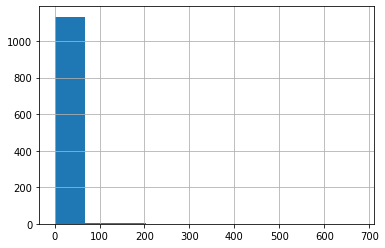

In [22]:
tweet_df["favorite_count"].hist() # create a histogram show the favorite count